<h1><center>Text detection in an image afflicted by noise</center></h1>

<h2><center>Part 1: Noise removal using filters</center></h2>

<p>In this project we will try to Detect text in an image. We will also take a look on how to clear the image of noice if there is any using specific methods for each noise type. Lets first import the needed libraries for the project.</p>

In [1]:
import numpy as np
import math
from cv2 import cv2 as cv
import matplotlib.pyplot as plt

image = cv.imread('res/image.png', cv.IMREAD_GRAYSCALE)
#The image is the one used in this stackoverflow thread, it does not belong to me
#https://stackoverflow.com/questions/75633751/find-the-co-ordinate-and-highlight-the-required-text-in-image-in-python
#You can use any image you like the code will run all the same

<p>We need then to create our functions. First of all we need a noisy image. We will use a clear image of a text and add on it some noise. The most common noise types are :
- Gaussian noise
- Salt And Pepper (SAP) noise
The Gaussian Noise follows the normal (or gaussian) distibution when applied to the image. It has a standard deviation and has a mean value equal to zero. The SAP noise is a percentage of random white or black pixels that are applied to the image. </p>

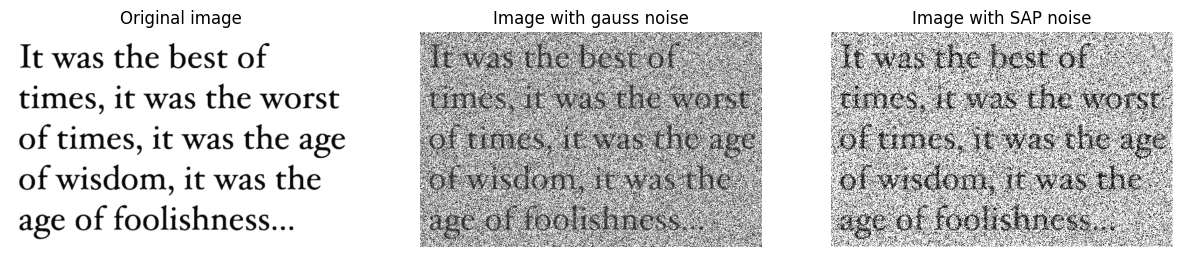

In [2]:
gauss_noise = cv.randn(np.zeros(image.shape, dtype=np.uint8), 0, 100)
gauss_noise = gauss_noise + image #We first generate the gauss-inflicted image

sap_noise = np.copy(image)
#In order to apply the SAP noise, we simply randomly choose to color a pixel
#white and another black for the amount equal to the size multiplicated with our ratio
sap_noise_ratio = 0.3
rng = np.random.default_rng()
num_of_pixels = int(sap_noise_ratio * sap_noise.shape[0] * sap_noise.shape[1])

x = rng.integers(low=0, high=sap_noise.shape[1] - 1, size=num_of_pixels)
y = rng.integers(low=0, high=sap_noise.shape[0] - 1, size=num_of_pixels)
for i in range(num_of_pixels):
    sap_noise[y[i]][x[i]] = 255

x = rng.integers(low=0, high=sap_noise.shape[1] - 1, size=num_of_pixels)
y = rng.integers(low=0, high=sap_noise.shape[0] - 1, size=num_of_pixels)
for i in range(num_of_pixels):
    sap_noise[y[i]][x[i]] = 0
        
fig, ax = plt.subplots(1, 3, figsize=(15, 9))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Original image')
ax[1].set_title('Image with gauss noise')
ax[2].set_title('Image with SAP noise')
ax[0].imshow(image, cmap='gray')
ax[1].imshow(gauss_noise, cmap='gray')
ax[2].imshow(sap_noise, cmap='gray')
plt.show()
#plt.figure(figsize=(15,15))
#plt.imshow(sap_noise, cmap='gray')

<p>Now that we have the noisy images, we will try to extract in which positions we have text. But first of all we need to clear up the image. The simple thing we can do is to pass the image through different filters. We will try 3 types of filters:
#1 Mean filter
#2 Gaussian filter
#3 Median filter
Lets try the filters first on the SAP noise. NOTE: For all filters we will use a kernel size of 5*5. Kernel size basically dictates the sliding window in which the algorithm will apply the transformation. a kernel size of 5*5 seems to present a good balance between performance and speed to run the code. In larger images, smaller kernel sizes may led to significant time waits.</p>

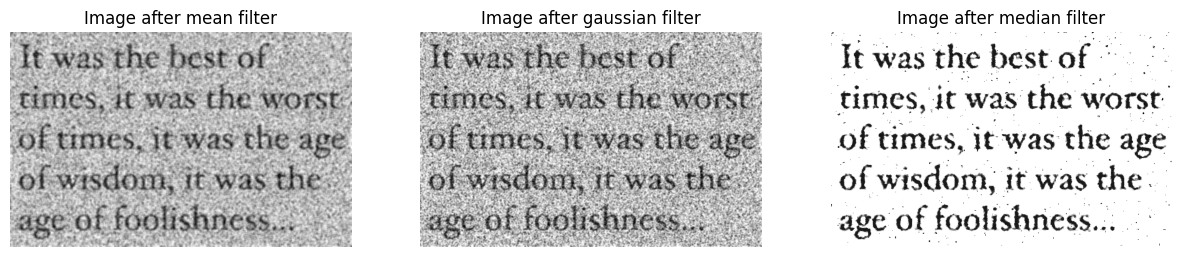

In [3]:
sap_mean = cv.blur(sap_noise, (5, 5))
sap_gaussian = cv.GaussianBlur(sap_noise, (5, 5), 0)
sap_median = cv.medianBlur(sap_noise, 5)
fig, ax = plt.subplots(1, 3, figsize=(15, 9))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Image after mean filter')
ax[1].set_title('Image after gaussian filter')
ax[2].set_title('Image after median filter')
ax[0].imshow(sap_mean, cmap='gray')
ax[1].imshow(sap_gaussian, cmap='gray')
ax[2].imshow(sap_median, cmap='gray')
plt.show()

<p>The difference is quite big, with the median filter almost fully removing the noise, while the other filters, while making the text stand out, have nowhere near the same level of success. Now lets try the gauss inflicted image.</p>

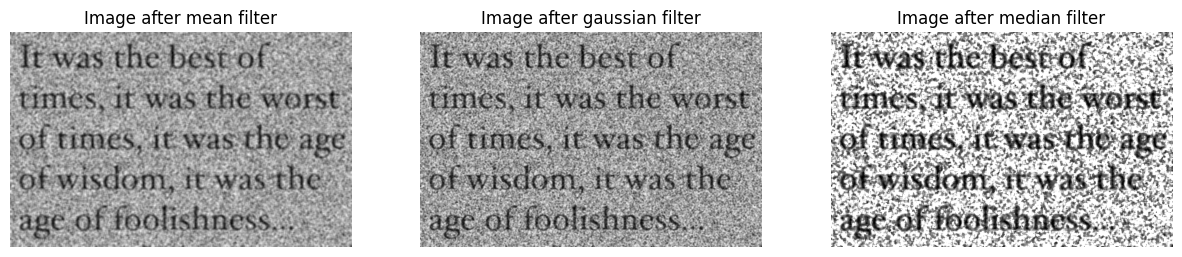

In [4]:
gaussian_noise_mean = cv.blur(gauss_noise, (5, 5))
gaussian_noise_gaussian = cv.GaussianBlur(gauss_noise, (5, 5), 0)
gaussian_noise_median = cv.medianBlur(gauss_noise, 5)
fig, ax = plt.subplots(1, 3, figsize=(15, 9))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Image after mean filter')
ax[1].set_title('Image after gaussian filter')
ax[2].set_title('Image after median filter')
ax[0].imshow(gaussian_noise_mean, cmap='gray')
ax[1].imshow(gaussian_noise_gaussian, cmap='gray')
ax[2].imshow(gaussian_noise_median, cmap='gray')
plt.show()

<p>We again see a big difference in the final result. This time, the median and gaussian filters show greater readability. Both will do fine. We will pick the mean filter, because as you can see below, we will repass the images through a gaussian filter to further smoothen the image.</p>
<p>The next thing we need to do in order to process the image is to apply thresholding. Specifically, we will transform the image such that the final product contains only the white and black colors and not the inbetween gray varieties. We will also invert the color so that the text is white, meaning his value is 255. Before we do any of that tho, we will pass the median-filtered images from a gaussian filter in order to smoothen the image.</p>
<p>Finally, we want to remove the remaining noise off the image. In order to do that, we will use the following morphological transformations:
- Erosion: We shrink the size of all bigger shapes. Effectively we make the text smaller.</p>
- Dilation: We increase the size of all bigger shapes. Effectively we make the text larger.</p>
- Opening: We perform an erosion and then a dilation. As a result, noise peripheral of the text is removed.</p>
- Erosion: We perform a dilation and then an erosion. As a result, noise inside the text is removed.</p>

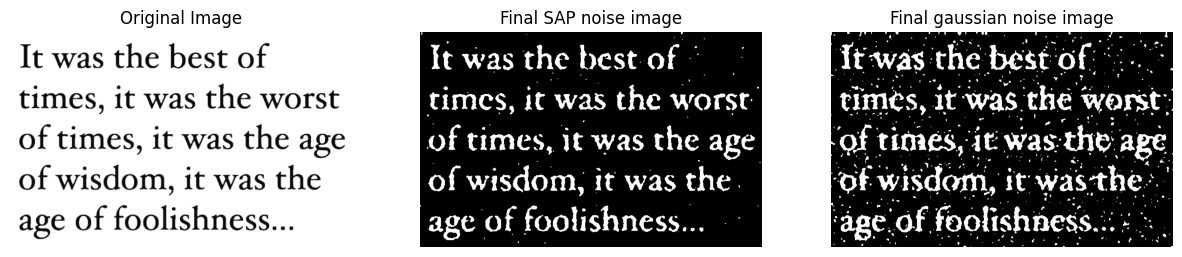

In [5]:
filtered_sap = cv.GaussianBlur(sap_median, (5, 5), 0)
filtered_gaussian = cv.GaussianBlur(gaussian_noise_mean, (5, 5), 0)
ret, processed_sap_image = cv.threshold(filtered_sap, 127, 255, cv.THRESH_OTSU | cv.THRESH_BINARY_INV)
ret, processed_gaussian_image = cv.threshold(filtered_gaussian, 127, 255, cv.THRESH_OTSU | cv.THRESH_BINARY_INV)
processed_sap_image = cv.morphologyEx(processed_sap_image, cv.MORPH_OPEN, (5, 5))            #Opening
processed_sap_image = cv.morphologyEx(processed_sap_image, cv.MORPH_CLOSE, (5, 5))           #Closing 
processed_gaussian_image = cv.morphologyEx(processed_gaussian_image, cv.MORPH_OPEN, (3, 3))
processed_gaussian_image = cv.morphologyEx(processed_gaussian_image, cv.MORPH_CLOSE, (3, 3))
fig, ax = plt.subplots(1, 3, figsize=(15, 9))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Original Image')
ax[1].set_title('Final SAP noise image')
ax[2].set_title('Final gaussian noise image')
ax[0].imshow(image, cmap='gray')
ax[1].imshow(processed_sap_image, cmap='gray')
ax[2].imshow(processed_gaussian_image, cmap='gray')
plt.show()

<p>We can clearly see the denoised image. The next step is to find the contours of the image. Contours are continuous same color objects, enabling us to detect shapes and, most importantly, characters. After that, all that remains is to filter smaller surface areas that could be noise, and the draw the bounding boxes of the detected text. We will also attempt to pass the image to pytesseract in order to try to translate into text.</p>

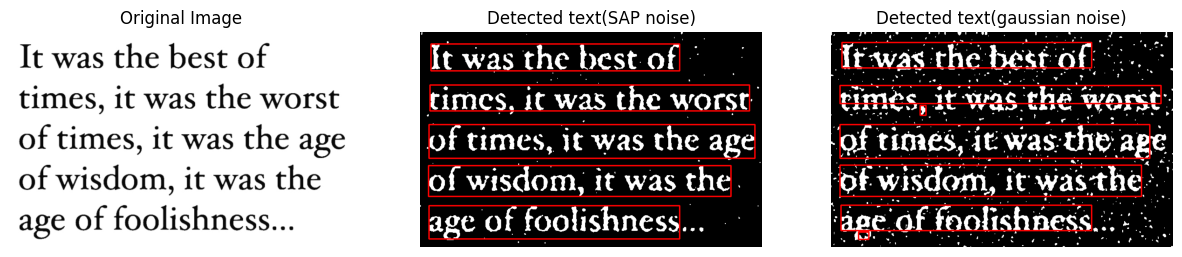

In [6]:
_, contours_sap, _ = cv.findContours(processed_sap_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
_, contours_gaussian, _ = cv.findContours(processed_gaussian_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

final_image_sap = cv.cvtColor(processed_sap_image,cv.COLOR_GRAY2RGB)
final_image_gaussian = cv.cvtColor(processed_gaussian_image,cv.COLOR_GRAY2RGB)

bounding_boxes = []
for contour in contours_sap:
    x, y, w, h = cv.boundingRect(contour)
    if(w * h > 200): #This is in order to not have noise in boxes
        bounding_boxes.append([x, y, w, h])
bounding_boxes.sort(key=lambda box:box[1])

rows = []
row = [bounding_boxes[0]]
for i in range(1, len(bounding_boxes)):
    x, y, w, h = bounding_boxes[i]
    _, prev_y, _, prev_h = row[-1]
    if(abs(y - prev_y) <= 25) or (abs(y + h - prev_h - prev_y)) <= 25:#<-------Threshold values for bounding boxes, current=25
        row.append(bounding_boxes[i])
    else:
        rows.append(row)
        row = []
        row.append(bounding_boxes[i])
if(row):
    rows.append(row)
    
for row in rows:
        x1 = min(row, key= lambda x: x[0])[0]
        x2 = max(row, key=lambda x: x[0])[0] + max(row, key=lambda x: x[0])[2]
        y1 = min(row, key=lambda x:x[1])[1]
        y2 = max(row, key=lambda x:x[1])[1] + max(row, key=lambda x:x[1])[3]
        cv.rectangle(final_image_sap, (x1, y1), (x2, y2), (255, 0, 0), 2)
    

bounding_boxes = []
for contour in contours_gaussian:
    x, y, w, h = cv.boundingRect(contour)
    if(w * h > 200): #This is in order to not have noise in boxes
        bounding_boxes.append([x, y, w, h])
bounding_boxes.sort(key=lambda box:box[1])

rows = []
row = [bounding_boxes[0]]
for i in range(1, len(bounding_boxes)):
    x, y, w, h = bounding_boxes[i]
    _, prev_y, _, prev_h = row[-1]
    if(abs(y - prev_y) <= 16) or (abs(y + h - prev_h - prev_y)) <= 16: #<-------Threshold values for bounding boxes, current=16
        row.append(bounding_boxes[i])
    else:
        rows.append(row)
        row = []
        row.append(bounding_boxes[i])
if(row):
    rows.append(row)
    
for row in rows:
        x1 = min(row, key= lambda x: x[0])[0]
        x2 = max(row, key=lambda x: x[0])[0] + max(row, key=lambda x: x[0])[2]
        y1 = min(row, key=lambda x:x[1])[1]
        y2 = max(row, key=lambda x:x[1])[1] + max(row, key=lambda x:x[1])[3]
        cv.rectangle(final_image_gaussian, (x1, y1), (x2, y2), (255, 0, 0), 2)


fig, ax = plt.subplots(1, 3, figsize=(15, 9))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Original Image')
ax[1].set_title('Detected text(SAP noise)')
ax[2].set_title('Detected text(gaussian noise)')
ax[0].imshow(image, cmap='gray')
ax[1].imshow(final_image_sap, cmap='gray')
ax[2].imshow(final_image_gaussian, cmap='gray')
plt.show()

<p>Despite the little inaccuracies in the rectangle selection, We can see that we succesfully detected the text! In case you want to try the program with one of your own texts, if the bounding boxes are not the expected, change the threshold value of the row detection.</p>
<p>In the end the 2 simple filters we used proved enough to remove enough noise in order to recognize the text rows. What if we needed even better visibility or we needed to read exactly the text's lines?</p>

<h2><center>Part 2: Noise removal using autoencoders</center></h2>

In this part, we will attempt to use tensorflow's models in order to recognize text from a noisy image. The link of the dataset is from [here](https://www.kaggle.com/competitions/denoising-dirty-documents/data)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D, ZeroPadding2D, Dropout, BatchNormalization
import gc
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

After importing the required arrays, we need to load our images.

In [8]:
img_w, img_h = 512, 256
batch_size=16
latent_dim = 64
val_data = 0.2

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory="res/train",
    labels=None,
    label_mode=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_h, img_w),
    shuffle=False
)

cleared_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory="res/train_cleaned",
    labels=None,
    label_mode=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_h, img_w),
    shuffle=False
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory="res/test",
    labels=None,
    color_mode='rgb',
    label_mode=None,
    batch_size=batch_size,
    image_size=(img_h, img_w),
    shuffle=False
)

def normalize_image(image):
    image = tf.cast(image, tf.float32) / 255.0  # Scale to [0,1]
    return image

train_data = train_data.map(lambda x: normalize_image(x))
cleared_data = cleared_data.map(lambda x: normalize_image(x))
test_data = test_data.map(lambda x: normalize_image(x))

train_dataset = tf.data.Dataset.zip((train_data, cleared_data))

Found 144 files belonging to 1 classes.
Found 144 files belonging to 1 classes.
Found 72 files belonging to 1 classes.


In [9]:
total_batches = 144 // batch_size
validation_steps = int(total_batches * val_data)
validation_dataset = train_dataset.take(validation_steps)
train_dataset.skip(validation_steps)

<SkipDataset element_spec=(TensorSpec(shape=(None, 256, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 512, 3), dtype=tf.float32, name=None))>

We remember to normalize the image, as the model will work properly only with values ranging from 0 to 1. In our case, we have 0 to 255.<br>
Now that we have the data ready, we need to create a model.

In [10]:
model = tf.keras.models.Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(img_h, img_w, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return mse + 0.2 * ssim  # Adjust weight as needed
    
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 512, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 512, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 256, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 256, 128)    512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 256, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 256, 128)     1

We constructed and compiled our model. What did we do though? We passed the data through 2 convolutional filters which extracted as much data as possible from the image, then we applied batch normalization and dropout. Batch normalization is used to smoothen and help the process of finding patterns, while dropout is used as a mean to stop the algorithm from overfitting, meaning getting used too much on the training data and being unable to decode external data properly. All that remains is to fit our model and see the results!

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(train_dataset,
         validation_data=validation_dataset,
         epochs=200,
         batch_size=batch_size,
         shuffle=True
         )#,callbacks=[callback])

Epoch 1/200
9/9 [==============================] - 12s 629ms/step - loss: 0.1520 - mae: 0.3129 - val_loss: 0.1746 - val_mae: 0.4050
Epoch 2/200
9/9 [==============================] - 3s 353ms/step - loss: 0.0794 - mae: 0.2162 - val_loss: 0.1247 - val_mae: 0.3406
Epoch 3/200
9/9 [==============================] - 3s 353ms/step - loss: 0.0589 - mae: 0.1795 - val_loss: 0.0975 - val_mae: 0.2955
Epoch 4/200
9/9 [==============================] - 3s 353ms/step - loss: 0.0475 - mae: 0.1576 - val_loss: 0.0814 - val_mae: 0.2597
Epoch 5/200
9/9 [==============================] - 3s 351ms/step - loss: 0.0395 - mae: 0.1414 - val_loss: 0.0721 - val_mae: 0.2312
Epoch 6/200
9/9 [==============================] - 3s 354ms/step - loss: 0.0336 - mae: 0.1278 - val_loss: 0.0660 - val_mae: 0.2084
Epoch 7/200
9/9 [==============================] - 3s 353ms/step - loss: 0.0289 - mae: 0.1175 - val_loss: 0.0642 - val_mae: 0.1903
Epoch 8/200
9/9 [==============================] - 3s 351ms/step - loss: 0.0250 - 

Thats quite a low loss level! Lets the the metrics through the training process.

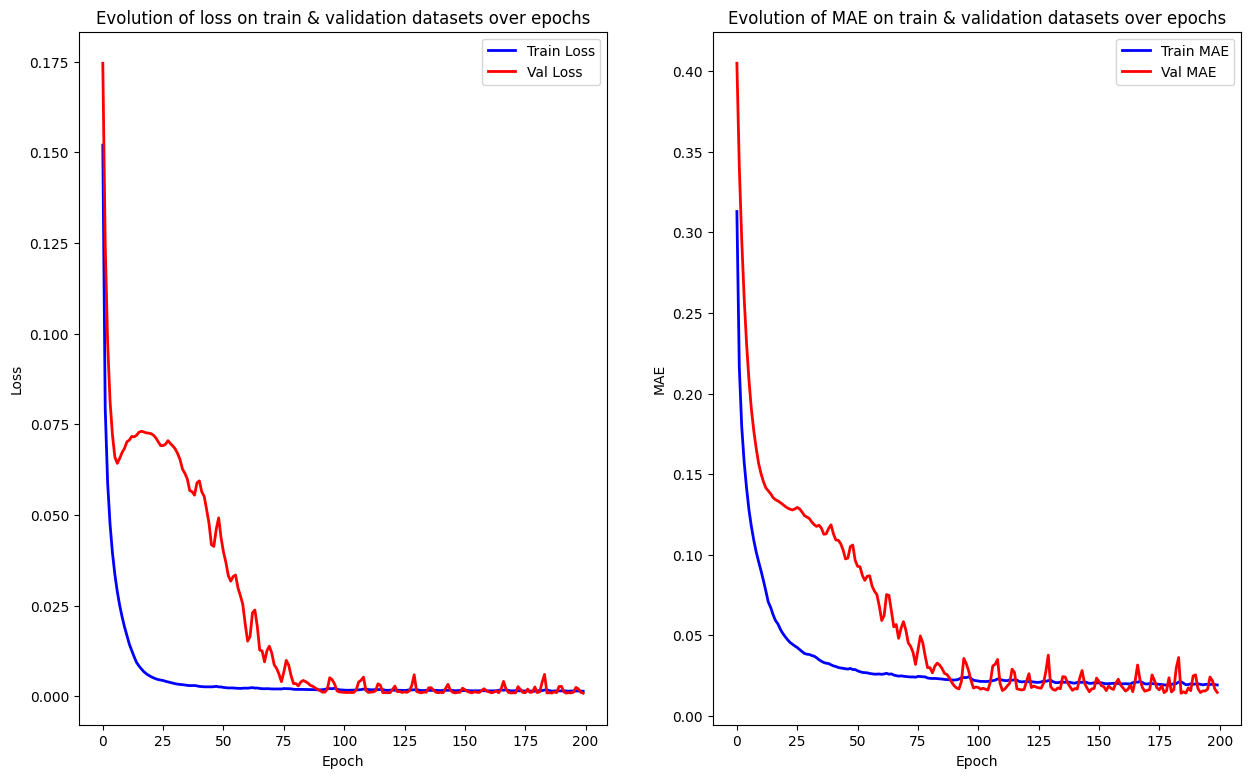

In [17]:
model.save('res/autoencoder_weights.h5')

epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

fig, ax = plt.subplots(1, 2, figsize=(15,9))
ax[0].plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
ax[0].plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
ax[0].set_title('Evolution of loss on train & validation datasets over epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')

ax[1].plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
ax[1].plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
ax[1].set_title('Evolution of MAE on train & validation datasets over epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAE')
ax[1].legend(loc='best')

Finally, lets compare side by side our work.

5/5 [==============================] - 3s 680ms/step


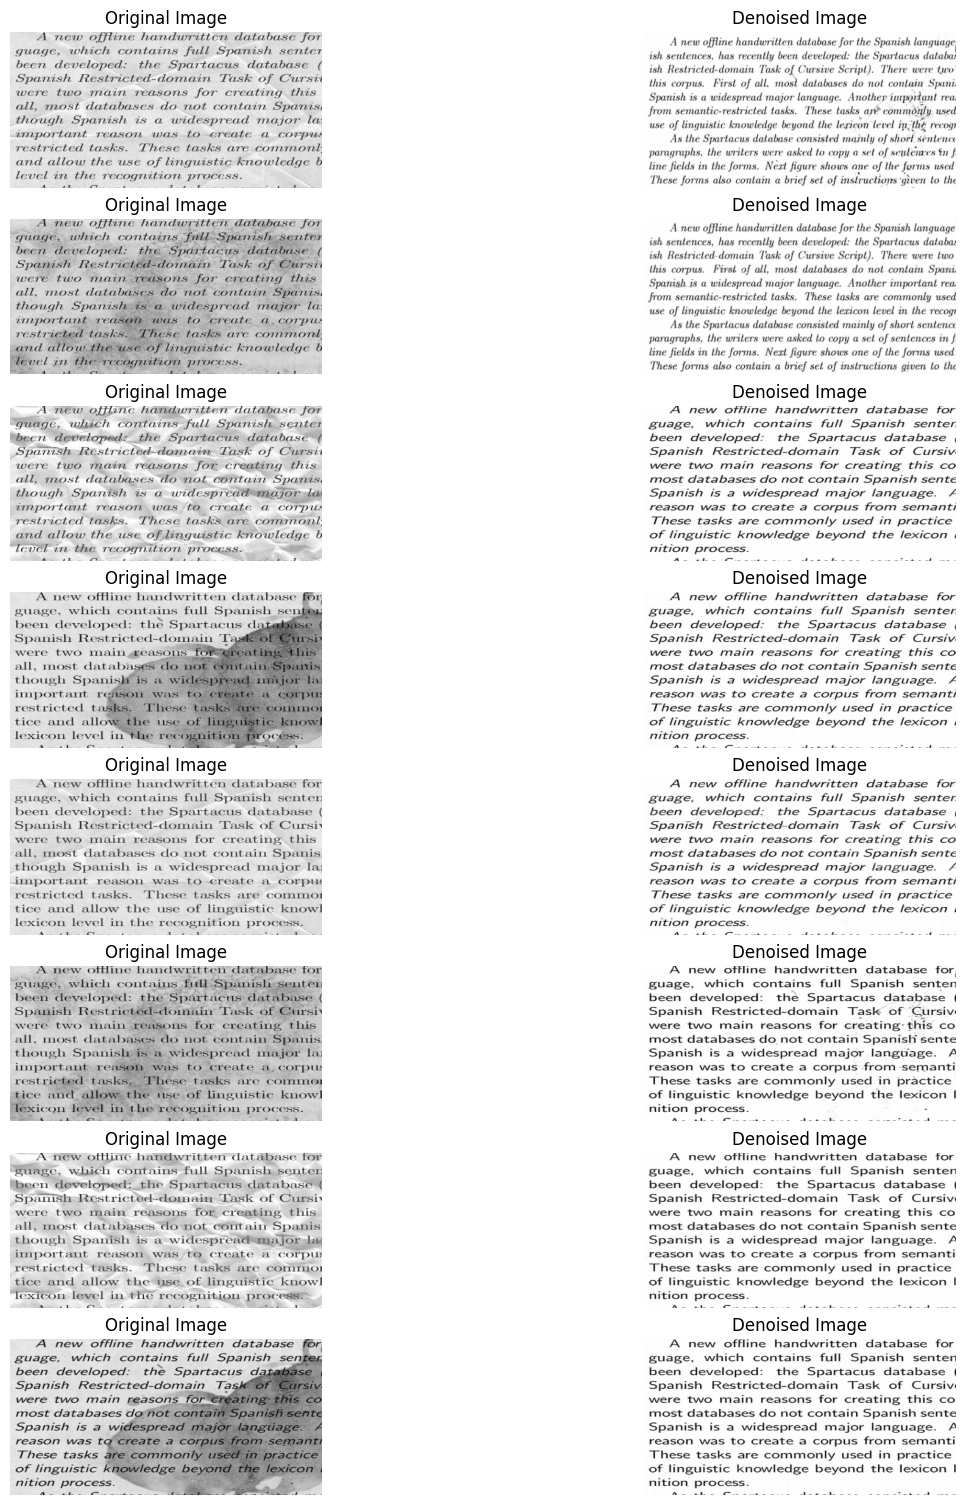

In [18]:
decoded_imgs = model.predict(test_data)
decoded_imgs = np.clip(decoded_imgs, 0, 1)
fix, ax = plt.subplots(8, 2, figsize=(15, 19))
for batch_x in test_data:
    for i in range(8):
        ax[i, 0].imshow(np.asarray(batch_x[i]))
        ax[i, 0].axis('off')
        ax[i, 0].set_title('Original Image')
        ax[i, 1].imshow(decoded_imgs[i])
        ax[i, 1].axis('off')
        ax[i, 1].set_title('Denoised Image')
plt.show()

The result, as expected is much more impressive, although quite more complicated and more expensive resource and time wise.